# Spectroscopic Production Database Tutorial

## Abstract

This tutorial will cover the basics of using the spectroscopic production database, which is loaded from the outputs of the DESI pipeline.  Currently, this is based on software "release" `main`, and uses a [PostgreSQL](https://www.postgresql.org/) database. We use [SQLAlchemy](http://www.sqlalchemy.org/) to abstract away the details of the database.

## Requirements

This tutorial uses data from the `fuji` production (`/global/cfs/cdirs/desi/public/edr/spectro/redux/fuji`), and the **DESI main** kernel.

## Initial Setup

This just imports everything we need and sets up paths and environment variables so we can find things.

In [1]:
#
# Imports
#
import os
from argparse import Namespace
from types import MethodType
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager, FontProperties
from sqlalchemy import __version__ as sqlalchemy_version
from sqlalchemy import inspect
from sqlalchemy.sql import func
import astropy.units as u
from astropy.constants import c as lightspeed
from astropy.table import Table, MaskedColumn
#
# DESI software
#
from desiutil.log import get_logger, DEBUG
from desitarget.targetmask import (desi_mask, mws_mask, bgs_mask)
# from desisim.spec_qa import redshifts as dsq_z
from desisurvey import __version__ as desisurvey_version
from desisurvey.ephem import get_ephem, get_object_interpolator
from desisurvey.utils import get_observer
from desispec import __version__ as desispec_version
import desispec.database.redshift as db
#
# Paths to files, etc.
#
specprod = os.environ['SPECPROD'] = 'fuji'
basedir = os.path.join(os.environ['DESI_SPECTRO_REDUX'], specprod)
# surveydir = os.environ['DESISURVEY_OUTPUT'] = os.path.join(basedir, 'survey')
# targetdir = os.path.join(basedir, 'targets')
# fibassigndir = os.path.join(basedir, 'fiberassign')
# os.environ['DESI_SPECTRO_REDUX'] = os.path.join(basedir, 'spectro', 'redux')
# os.environ['DESI_SPECTRO_SIM'] = os.path.join(basedir, 'spectro', 'sim')
# os.environ['PIXPROD'] = 'mini'
# os.environ['SPECPROD'] = 'mini'
# reduxdir = os.path.join(os.environ['DESI_SPECTRO_REDUX'], os.environ['SPECPROD'])
# simdatadir = os.path.join(os.environ['DESI_SPECTRO_SIM'], os.environ['PIXPROD'])
# os.environ['DESI_SPECTRO_DATA'] = simdatadir
#
# Initialize ephemerides, to find Moon, etc.
#
os.environ['DESISURVEY_OUTPUT'] = os.environ['SCRATCH']
ephem = get_ephem()
#
# get_ephem() will run freeze_iers(), so we import these after that.
#
from astropy.time import Time
from astropy.coordinates import ICRS
#
# Working directory.
#
workingdir = os.getcwd()
print(f'sqlalchemy=={sqlalchemy_version}')
print(f'desispec=={desispec_version}')
print(f'desisurvey=={desisurvey_version}')

INFO:iers.py:82:freeze_iers: Freezing IERS table used by astropy time, coordinates.
INFO:ephem.py:80:get_ephem: Restored ephemerides for (2019-01-01,2027-12-31) from /global/cscratch1/sd/ronitnag/ephem_2019-01-01_2027-12-31.fits.
sqlalchemy==1.4.28
desispec==0.57.0.dev7762
desisurvey==0.19.0.dev1131


This function will compute various Moon paramters needed below.

In [7]:
def moon(self, mjd, ra, dec):
    """Compute relative location of the Moon.
    
    Parameters
    ----------
    mjd : float
        Time of observation
    ra : float
        Right Ascension
    dec : float
        Declination
    
    Returns
    -------
    tuple
        Moon separation, Moon altitude, Moon illumination fraction
    """
    observation_time = Time(mjd, format='mjd')
    position = ICRS(ra=ra*u.deg, dec=dec*u.deg)
    zenith = get_observer(observation_time, alt=90 * u.deg, az=0 * u.deg).transform_to(ICRS)
    alt = 90 * u.deg - position.separation(zenith)
    moon_dec, moon_ra = get_object_interpolator(self.get_night(observation_time), 'moon', altaz=False)(observation_time.mjd)
    moon_position = ICRS(ra=moon_ra*u.deg, dec=moon_dec*u.deg)
    moon_sep = position.separation(moon_position).to(u.deg).value
    moon_alt = (90 * u.deg - moon_position.separation(zenith)).to(u.deg).value
    moon_frac = ephem.get_moon_illuminated_fraction(observation_time.mjd).tolist()
    return (moon_sep, moon_alt, moon_frac)

ephem.moon = MethodType(moon, ephem)

## Contents of the Database

All tables are grouped into a database *schema* and that schema is named for the production run, (*e.g.* `fuji`).  When writing "raw" SQL, table names need to be schema-qualified, for example, `fuji.target`.  However, the SQLAlchemy abstraction layer is designed to take care of this for you.

Important notes:

* This database does not contain any sky spectra. Both deliberately-targeted (`targetid & 2**59 != 0`) and negative targetid (`targetid < 0`) sky spectra are excluded.
* Only cumulative tile-based spectra are included at the present time.

The tables are:

* `photometry`. This contains the pure photometric data. Usually this is derived from the LS DR9 Tractor data, but not every *targeted* object has Tractor photometry.
  - Loaded from `tractorphot` files: `/global/cfs/cdirs/desi/public/edr/vac/lsdr9-photometry/v1.0/potential-targets/tractorphot/tractorphot-potential-*-${SPECPROD}.fits`.
  - SQLAlchemy object: `db.Photometry`.
  - Primary key: `targetid`.
* `target`. This contains the targeting bits and other data generated by `desitarget`.
  - Loaded from `targetphot` file: `/global/cfs/cdirs/desi/public/edr/vac/lsdr9-photometry/v1.0/potential-targets/targetphot-potential-${SPECPROD}.fits`.
  - SQLAlchemy object: `db.Target`.
  - Primary key: (`targetid`, `survey`, `tileid`)
* `tile`. This contains information about observations grouped by tile.
  - Loaded from top-level `tiles-${SPECPROD}.fits`.
  - SQLAlchemy object: `db.Tile`.
  - Primary key: `tileid`.
* `exposure`. This contains information about individual exposures.
  - Loaded from top-level `exposures-${SPECPROD}.fits`, `EXPOSURES` HDU.
  - SQLAlchemy object: `db.Exposure`.
  - Primary key: `expid`.
* `frame`. This contains information about individual exposures, but broken down by camera.  There will usually, but not always, be 30 frames per exposure.
  - Loaded from top-level `exposures-${SPECPROD.fits`, `FRAMES` HDU.
  - SQLAlchemy object: `db.Frame`.
  - Primary key: `frameid`, composed from `expid` and a mapping of `camera` to an arbitrary integer.
* `fiberassign`. This contains information about fiber positions.
  - Loaded from fiberassign files in the tiles product.  All fiberassign files corresponding to tiles in the `tile` table are loaded.
  - SQLAlchemy object: `db.Fiberassign`.
  - Primary key: (`tileid`, `targetid`, `location`)
* `potential`. This contains a list of `targetid`s that *could* have been targeted on a given tile.
  - Loaded from the `POTENTIAL_ASSIGNMENTS` HDU in the same fiberassign files mentioned above.
  - SQLAlchemy object: `db.Potential`.
  - Primary key: (`tileid`, `targetid`, `location`)
* `zpix`. This contains the pipeline redshifts grouped by HEALPixel.
  - Loaded from the `zall-pix-${SPECPROD}.fits` file in the `zcatalog/` directory.
  - SQLAlchemy object: `db.Zpix`.
  - Primary key: (`targetid`, `survey`, `program`)
* `ztile`. This contains the pipeline redshifts grouped by tile in a variety of ways.
  - Loaded from the `zall-tilecumulative-${SPECPROD}.fits` file in the `zcatalog/` directory.
  - SQLAlchemy object: `db.Ztile`
  - Primary key: (`targetid`, `spgrp`, `spgrpval`, `tileid`)

## Initial Database Connection

This connection uses a `~/.pgpass` file to set up connection credentials.  [Be sure you have set that up](https://desi.lbl.gov/trac/wiki/DESIProductionDatabase#Setuppgpass).

In [2]:
#
# For much more output, use DEBUG/verbose mode.
#
# db.log = get_logger(DEBUG)
# postgresql = db.setup_db(schema=specprod, hostname='nerscdb03.nersc.gov', username='desi', verbose=True)
db.log = get_logger()
postgresql = db.setup_db(schema=specprod, hostname='nerscdb03.nersc.gov', username='desi')

## Learning About the Tables

The tables in the database are listed above.  To inspect an individual table, you can use the `__table__` attribute.

In [3]:
#
# Print the table columns and their types.
#
pix_names = set()
tile_names = set()

for c in db.Zpix.__table__.columns:
    pix_names.add(c.name)

for c in db.Ztile.__table__.columns:
    tile_names.add(c.name)

print(pix_names.difference(tile_names))
print(tile_names.difference(pix_names))

{'healpix'}
{'targetphotid', 'tileid'}


We can also `inspect()` the database.  For details see [here](http://docs.sqlalchemy.org/en/latest/core/inspection.html?highlight=inspect#module-sqlalchemy.inspection).

In [72]:
with open ('Table_Columns.txt', 'w') as file:  
    inspector = inspect(db.engine)
    for table_name in inspector.get_table_names(schema=specprod):
        file.write(f'------ {table_name} ------\n')
        for column in inspector.get_columns(table_name, schema=specprod):
            file.write("Column: {name} {type} \n".format(**column))
        file.write('\n')
    file.close()

In [4]:
table_aliases = {
    'fiberassign' : 'fb',
    'version' : 'v',
    'potential' : 'pt',
    'zpix' : 'zp',
    'photometry' : 'ph',
    'frame' : 'fr',
    'target' : 'tg',
    'ztile' : 'zt',
    'tile' : 't',
    'exposure' : 'ex'
}

In [5]:
inspector = inspect(db.engine)
table_sets = dict()
for table_name in inspector.get_table_names(schema=specprod):
    print(table_name)
    s = set()
    for column in inspector.get_columns(table_name, schema=specprod):
        s.add(f'{table_aliases[table_name]}.{column["name"]}')
    table_sets[table_name] = s
    """
    for column in inspector.get_columns(table_name, schema=specprod):
        print("Column: {name} {type}".format(**column))
    """

fiberassign
version
potential
zpix
photometry
frame
target
ztile
tile
exposure


In [6]:
def tableColIntersect(set1, set2):
    s1 = set()
    name1 = ""
    for item in set1:
        name1 = item.split('.')[0]
        s1.add(item.split('.')[1])
        
    s2 = set()
    name2 = ""
    for item in set2:
        name2 = item.split('.')[0]
        s2.add(item.split('.')[1])
        
    intersect = s1.intersection(s2)
    equals = []
    for i in intersect:
        equals.append(f'{name1}.{i}={name2}.{i}')
        
    joinstring = ""
    if equals:
        joinstring = equals[0]
        for i in range(1, len(equals)):
            joinstring = joinstring + " AND " + equals[i]
        
    return joinstring

In [7]:
tableColIntersect(table_sets['target'], table_sets['fiberassign'])

'tg.targetid=fb.targetid AND tg.id=fb.id AND tg.tileid=fb.tileid'

In [8]:
def relationPath(tablenames, set_dict):
    for name in tablenames:
        if name not in set_dict:
            raise ValueError('tablenames are not available in provided set_dict')
    
    for level in range(1, len(tablenames)):
        lvl = ""
        for i in range(0, level):
            lvl = lvl + tableColIntersect(set_dict[tablenames[i]], set_dict[tablenames[level]])
            lvl = lvl + ' AND '
        print(f'level:{i+1}, {tablenames[i]} -> {tablenames[i+1]} | {lvl}')
            

In [9]:
relationPath(['photometry', 'target', 'fiberassign', 'tile', 'frame', 'ztile'], table_sets)

level:1, photometry -> target | ph.targetid=tg.targetid AND 
level:2, target -> fiberassign | ph.targetid=fb.targetid AND tg.targetid=fb.targetid AND tg.id=fb.id AND tg.tileid=fb.tileid AND 
level:3, fiberassign -> tile |  AND tg.survey=t.survey AND tg.program=t.program AND tg.tileid=t.tileid AND fb.tileid=t.tileid AND 
level:4, tile -> frame | ph.ebv=fr.ebv AND tg.tileid=fr.tileid AND fb.tileid=fr.tileid AND t.exptime=fr.exptime AND t.tileid=fr.tileid AND 
level:5, frame -> ztile | ph.targetid=zt.targetid AND tg.survey=zt.survey AND tg.id=zt.id AND tg.targetid=zt.targetid AND tg.program=zt.program AND tg.tileid=zt.tileid AND fb.targetid=zt.targetid AND fb.id=zt.id AND fb.tileid=zt.tileid AND t.survey=zt.survey AND t.program=zt.program AND t.tileid=zt.tileid AND fr.tsnr2_elg=zt.tsnr2_elg AND fr.tsnr2_bgs=zt.tsnr2_bgs AND fr.tsnr2_gpbdark=zt.tsnr2_gpbdark AND fr.tsnr2_lya=zt.tsnr2_lya AND fr.tsnr2_gpbbackup=zt.tsnr2_gpbbackup AND fr.tsnr2_lrg=zt.tsnr2_lrg AND fr.tsnr2_qso=zt.tsnr2_qso A

In [11]:
relationPath(['photometry', 'target', 'fiberassign', 'zpix'], table_sets)

level:1, photometry -> target | ph.targetid=tg.targetid AND 
level:2, target -> fiberassign | ph.targetid=fb.targetid AND tg.targetid=fb.targetid AND tg.id=fb.id AND tg.tileid=fb.tileid AND 
level:3, fiberassign -> zpix | ph.targetid=zp.targetid AND tg.id=zp.id AND tg.survey=zp.survey AND tg.targetid=zp.targetid AND tg.program=zp.program AND fb.targetid=zp.targetid AND fb.id=zp.id AND 


In [158]:
def dupeColumns(s):
    cols = s.split('|')
    for i in range(len(cols)):
        cols[i] = cols[i].strip().replace("\n", "")
    
    s = set()
    dupes = set()
    for col in cols:
        if col in s:
            dupes.add(col)
        else:
            s.add(col)
    return dupes

In [159]:
s = """ ls_id | release | brickid | brickname | brick_objid | morphtype | ra | ra_ivar | dec | dec_ivar | dchisq_psf | dchisq_rex | dchisq_dev | dchisq_exp | dchisq_ser | ebv | flux_g | flux_r | flux_z | flux_ivar_g | flux_ivar_r | flux_ivar_z | mw_transmission_g | mw_transmission_r | mw_transmission_z | fracflux_g | fracflux_r | fracflux_z | fracmasked_g | fracmasked_r | fracmasked_z | fracin_g | fracin_r | fracin_z | nobs_g | nobs_r | nobs_z | psfdepth_g | psfdepth_r | psfdepth_z | galdepth_g | galdepth_r | galdepth_z | flux_w1 | flux_w2 | flux_w3 | flux_w4 | flux_ivar_w1 | flux_ivar_w2 | flux_ivar_w3 | flux_ivar_w4 | mw_transmission_w1 | mw_transmission_w2 | mw_transmission_w3 | mw_transmission_w4 | allmask_g | allmask_r | allmask_z | fiberflux_g | fiberflux_r | fiberflux_z | fibertotflux_g | fibertotflux_r | fibertotflux_z | ref_epoch | wisemask_w1 | wisemask_w2 | maskbits | shape_r | shape_e1 | shape_e2 | shape_r_ivar | shape_e1_ivar | shape_e2_ivar | sersic | sersic_ivar | ref_id | ref_cat | gaia_phot_g_mean_mag | gaia_phot_g_mean_flux_over_error | gaia_phot_bp_mean_mag | gaia_phot_bp_mean_flux_over_error | gaia_phot_rp_mean_mag | gaia_phot_rp_mean_flux_over_error | gaia_phot_bp_rp_excess_factor | gaia_duplicated_source | gaia_astrometric_sigma5d_max | gaia_astrometric_params_solved | parallax | parallax_ivar | pmra | pmra_ivar | pmdec | pmdec_ivar | targetid | id | targetid | photsys | subpriority | obsconditions | priority_init | numobs_init | hpxpixel | cmx_target | desi_target | bgs_target | mws_target | sv1_desi_target | sv1_bgs_target | sv1_mws_target | sv2_desi_target | sv2_bgs_target | sv2_mws_target | sv3_desi_target | sv3_bgs_target | sv3_mws_target | scnd_target | sv1_scnd_target | sv2_scnd_target | sv3_scnd_target | survey | program | tileid | id | tileid | targetid | petal_loc | device_loc | location | fiber | fiberstatus | target_ra | target_dec | lambda_ref | fa_target | fa_type | fiberassign_x | fiberassign_y | priority | plate_ra | plate_dec | tileid | survey | program | faprgrm | faflavor | nexp | exptime | tilera | tiledec | efftime_etc | efftime_spec | efftime_gfa | goaltime | obsstatus | lrg_efftime_dark | elg_efftime_dark | bgs_efftime_bright | lya_efftime_dark | goaltype | mintfrac | lastnight | frameid | night | expid | tileid | mjd | exptime | ebv | camera | tsnr2_gpbdark | tsnr2_elg | tsnr2_gpbbright | tsnr2_lya | tsnr2_bgs | tsnr2_gpbbackup | tsnr2_qso | tsnr2_lrg | id | targetphotid | targetid | survey | program | spgrp | spgrpval | z | zerr | zwarn | chi2 | coeff_0 | coeff_1 | coeff_2 | coeff_3 | coeff_4 | coeff_5 | coeff_6 | coeff_7 | coeff_8 | coeff_9 | npixels | spectype | subtype | ncoeff | deltachi2 | coadd_fiberstatus | tileid | coadd_numexp | coadd_exptime | coadd_numnight | coadd_numtile | mean_delta_x | rms_delta_x | mean_delta_y | rms_delta_y | mean_fiber_ra | std_fiber_ra | mean_fiber_dec | std_fiber_dec | mean_psf_to_fiber_specflux | tsnr2_gpbdark_b | tsnr2_elg_b | tsnr2_gpbbright_b | tsnr2_lya_b | tsnr2_bgs_b | tsnr2_gpbbackup_b | tsnr2_qso_b | tsnr2_lrg_b | tsnr2_gpbdark_r | tsnr2_elg_r | tsnr2_gpbbright_r | tsnr2_lya_r | tsnr2_bgs_r | tsnr2_gpbbackup_r | tsnr2_qso_r | tsnr2_lrg_r | tsnr2_gpbdark_z | tsnr2_elg_z | tsnr2_gpbbright_z | tsnr2_lya_z | tsnr2_bgs_z | tsnr2_gpbbackup_z | tsnr2_qso_z | tsnr2_lrg_z | tsnr2_gpbdark | tsnr2_elg | tsnr2_gpbbright | tsnr2_lya | tsnr2_bgs | tsnr2_gpbbackup | tsnr2_qso | tsnr2_lrg | sv_nspec | sv_primary | main_nspec | main_primary | zcat_nspec | zcat_primary """

In [160]:
dupeColumns(s)

{'ebv',
 'exptime',
 'id',
 'program',
 'survey',
 'targetid',
 'tileid',
 'tsnr2_bgs',
 'tsnr2_elg',
 'tsnr2_gpbbackup',
 'tsnr2_gpbbright',
 'tsnr2_gpbdark',
 'tsnr2_lrg',
 'tsnr2_lya',
 'tsnr2_qso'}

### Exercises

* What is the type of the `night` column of the `exposures` table?
* What is the primary key of the `ztile` table?

In [12]:
db.Exposure.__table__.columns.night.type

Integer()

In [20]:
db.Ztile

desispec.database.redshift.Ztile

## Simple Queries

Queries are set up with the `.query()` method on Session objects.  In this case, there's a prepared Session object called `db.dbSession`.  `.filter()` corresponds to a `WHERE` clause in SQL.

In most of the examples below, we include the equivalent raw SQL command that corresponds to the query.

### Exposures, Nights, Tiles

Here are some simple queries that demonstrate simple connections between nights, exposures and tiles.

#### How many tiles are there?

```SQL
SELECT COUNT(tileid) FROM fuji.tile;
```

In [ ]:
q = db.dbSession.query(db.Tile).count()
q

#### On which nights were a particular tile observed?

```SQL
SELECT night, expid FROM fuji.exposure WHERE tileid = 100;
```

In [23]:
q = db.dbSession.query(db.Exposure.night, db.Exposure.expid).filter(db.Exposure.tileid == 100).all()
q

[(20210504, 87236), (20210505, 87361)]

#### Which tiles were observed on a night?

```SQL
SELECT tileid, survey, program FROM fuji.exposure WHERE night = 20210115;
```

In [27]:
q = db.dbSession.query(db.Exposure.tileid, db.Exposure.survey, db.Exposure.program).filter(db.Exposure.night == 20210115).all()
q

[(80655, 'sv1', 'bright'),
 (80680, 'sv1', 'dark'),
 (80680, 'sv1', 'dark'),
 (80660, 'sv1', 'bright'),
 (80660, 'sv1', 'bright'),
 (80715, 'sv1', 'other'),
 (80715, 'sv1', 'other'),
 (80715, 'sv1', 'other'),
 (80674, 'sv1', 'dark'),
 (80674, 'sv1', 'dark'),
 (80674, 'sv1', 'dark'),
 (80683, 'sv1', 'dark'),
 (80683, 'sv1', 'dark'),
 (80678, 'sv1', 'dark'),
 (80678, 'sv1', 'dark'),
 (80688, 'sv1', 'dark'),
 (80688, 'sv1', 'dark'),
 (80685, 'sv1', 'dark'),
 (80685, 'sv1', 'dark'),
 (80662, 'sv1', 'bright'),
 (80662, 'sv1', 'bright'),
 (80663, 'sv1', 'bright'),
 (80663, 'sv1', 'bright'),
 (80690, 'sv1', 'dark'),
 (80690, 'sv1', 'dark'),
 (80653, 'sv1', 'bright'),
 (80653, 'sv1', 'bright'),
 (80700, 'sv1', 'dark'),
 (80700, 'sv1', 'dark'),
 (80699, 'sv1', 'dark'),
 (80699, 'sv1', 'dark'),
 (80665, 'sv1', 'bright'),
 (80665, 'sv1', 'bright'),
 (80707, 'sv1', 'dark'),
 (80707, 'sv1', 'dark')]

### Select ELG Targets

Note the special way we obtain the bitwise AND operator (`desi_mask.ELG == 2**1`).

```SQL
SELECT * from fuji.target WHERE (desi_target & 2) != 0;
```

In [29]:
q = db.dbSession.query(db.Target).filter(db.Target.desi_target.op('&')(desi_mask.ELG) != 0).all()
q[:10]

[Target(targetid=39628273327539288, tileid=81100, survey='special'),
 Target(targetid=39628273327539304, tileid=81100, survey='special'),
 Target(targetid=39628273327539661, tileid=81100, survey='special'),
 Target(targetid=39628273327540514, tileid=81100, survey='special'),
 Target(targetid=39628273327539105, tileid=81100, survey='special'),
 Target(targetid=39628273327540710, tileid=81100, survey='special'),
 Target(targetid=39628273327541426, tileid=81100, survey='special'),
 Target(targetid=39628273327541480, tileid=81100, survey='special'),
 Target(targetid=39628273327541945, tileid=81100, survey='special'),
 Target(targetid=39628273327542474, tileid=81100, survey='special')]

In [30]:
[(row.targetid, row.desi_target, row.survey, row.program, row.tileid) for row in q[:10]]

[(39628273327539288, 655458, 'special', 'dark', 81100),
 (39628273327539304, 4611686018428305446, 'special', 'dark', 81100),
 (39628273327539661, 655458, 'special', 'dark', 81100),
 (39628273327540514, 655394, 'special', 'dark', 81100),
 (39628273327539105, 4611686018428305446, 'special', 'dark', 81100),
 (39628273327540710, 655458, 'special', 'dark', 81100),
 (39628273327541426, 655458, 'special', 'dark', 81100),
 (39628273327541480, 655394, 'special', 'dark', 81100),
 (39628273327541945, 917542, 'special', 'dark', 81100),
 (39628273327542474, 917606, 'special', 'dark', 81100)]

#### Exercise

* How many objects in the `zpix` table have `spectype` 'GALAXY'?

In [37]:
db.dbSession.query(db.Zpix).filter(db.Zpix.spectype == 'GALAXY').count()

1303237

### Redshift and Classification

Simple query filtering on string values. Note that the slice notation `[:20]` is equivalent to `LIMIT 20` in SQL.

```SQL
SELECT spectype, subtype, z FROM fuji.zpix WHERE spectype = 'STAR' AND subtype != '' LIMIT 20;
```

In [41]:
db.dbSession.query(db.Zpix.spectype, db.Zpix.subtype, db.Zpix.z).filter(db.Zpix.spectype == 'STAR').filter(db.Zpix.subtype != '')[:20]

[('STAR', 'CV', -0.00199569129234795),
 ('STAR', 'M', -3.75605406508605e-05),
 ('STAR', 'G', -6.60747391019077e-05),
 ('STAR', 'M', 9.8335838129404e-05),
 ('STAR', 'CV', -0.00199569129234795),
 ('STAR', 'CV', -0.00199569129234795),
 ('STAR', 'K', -0.000187595450424383),
 ('STAR', 'G', -0.000245578117524253),
 ('STAR', 'CV', -0.00199569129234795),
 ('STAR', 'CV', -0.00199569129234795),
 ('STAR', 'K', 0.000100795469925271),
 ('STAR', 'CV', -0.00199569129234795),
 ('STAR', 'CV', -0.00199569129234795),
 ('STAR', 'CV', -0.00199569129234795),
 ('STAR', 'CV', -0.00199569129234795),
 ('STAR', 'CV', -0.00199569129234795),
 ('STAR', 'CV', -0.00199569129234795),
 ('STAR', 'M', -8.97785163529219e-05),
 ('STAR', 'M', -4.33558174813776e-05),
 ('STAR', 'CV', -0.00199569129234795)]

In [43]:
q = db.dbSession.query(db.Zpix.spectype, db.Zpix.subtype, db.Zpix.z).filter(db.Zpix.spectype == 'STAR').filter(db.Zpix.subtype != '')[:20]
q

[('STAR', 'CV', -0.00199569129234795),
 ('STAR', 'M', -3.75605406508605e-05),
 ('STAR', 'G', -6.60747391019077e-05),
 ('STAR', 'M', 9.8335838129404e-05),
 ('STAR', 'CV', -0.00199569129234795),
 ('STAR', 'CV', -0.00199569129234795),
 ('STAR', 'K', -0.000187595450424383),
 ('STAR', 'G', -0.000245578117524253),
 ('STAR', 'CV', -0.00199569129234795),
 ('STAR', 'CV', -0.00199569129234795),
 ('STAR', 'K', 0.000100795469925271),
 ('STAR', 'CV', -0.00199569129234795),
 ('STAR', 'CV', -0.00199569129234795),
 ('STAR', 'CV', -0.00199569129234795),
 ('STAR', 'CV', -0.00199569129234795),
 ('STAR', 'CV', -0.00199569129234795),
 ('STAR', 'CV', -0.00199569129234795),
 ('STAR', 'M', -8.97785163529219e-05),
 ('STAR', 'M', -4.33558174813776e-05),
 ('STAR', 'CV', -0.00199569129234795)]

## Joining Tables

### A Simple Join

Let's look at the nights and exposures on which a particular `TARGETID` was observed.

```SQL
SELECT f.tileid, e.expid, e.night FROM fuji.fiberassign AS f JOIN fuji.exposure AS e ON f.tileid = e.tileid WHERE f.targetid = 933811403620352;
```

In [44]:
q = db.dbSession.query(db.Fiberassign.tileid, db.Exposure.expid, db.Exposure.night).filter(db.Fiberassign.tileid == db.Exposure.tileid).filter(db.Fiberassign.targetid == 933811403620352).all()
q

[(278, 85086, 20210416),
 (279, 85209, 20210417),
 (279, 85207, 20210417),
 (279, 85206, 20210417),
 (279, 85208, 20210417),
 (280, 86981, 20210502),
 (280, 86980, 20210502)]

### Another Simple Join

In this case, we'll look at photometric flux and measured redshift. We'll `ORDER`(`BY`) the results and `LIMIT` the query with slice notation.

```SQL
SELECT p.*, z.* FROM fuji.photometry AS p JOIN fuji.zpix AS z ON p.targetid = z.targetid ORDER BY z.z, p.flux_g LIMIT 50;
```

In [45]:
q = db.dbSession.query(db.Photometry, db.Zpix).filter(db.Photometry.targetid == db.Zpix.targetid).order_by(db.Zpix.z, db.Photometry.flux_g)[:50]

In [46]:
[(row.Photometry.flux_g, row.Photometry.flux_r, row.Photometry.flux_z, row.Zpix.z) for row in q]

[(0.0, 0.0, 0.0, -0.005),
 (0.0, 0.0, 0.0, -0.005),
 (0.0, 0.0, 0.0, -0.005),
 (0.288389, 0.399304, 0.658613, -0.005),
 (0.371317, 0.500192, 0.926787, -0.005),
 (0.376231, 0.462276, 0.735718, -0.005),
 (0.402784, 0.492405, 0.729579, -0.005),
 (0.423864, 0.508099, 0.905529, -0.005),
 (0.645119, 0.751905, 1.32465, -0.005),
 (0.763588, 0.981288, 1.35165, -0.005),
 (0.801658, 1.18934, 1.3972, -0.005),
 (1.03619, 1.16814, 0.885411, -0.005),
 (1.97763, 7.93039, 17.0531, -0.005),
 (3.36023, 4.87858, 5.37419, -0.005),
 (30.6108, 42.9943, 46.7004, -0.005),
 (0.322118, 0.260959, 0.380534, -0.00498711921143957),
 (0.301417, 0.322585, 0.620725, -0.00498464799337274),
 (0.282215, 0.150698, 0.302225, -0.00498389817403406),
 (0.0, 0.0, 0.0, -0.00497712431274103),
 (0.289591, 0.421891, 0.285822, -0.00497480828100477),
 (0.758101, 1.3058, 2.06423, -0.00496785500847381),
 (0.321924, 0.229319, 0.286182, -0.00496686452525558),
 (6.79679, 12.0986, 14.6919, -0.00496137489562983),
 (0.943244, 1.34712, 1.6834

/tmp/ipykernel_17365/3953067757.py:4: RuntimeWarning: invalid value encountered in true_divide
  g_minus_r = np.log10(flux_r/flux_g)
/tmp/ipykernel_17365/3953067757.py:5: RuntimeWarning: invalid value encountered in true_divide
  r_minus_z = np.log10(flux_z/flux_r)


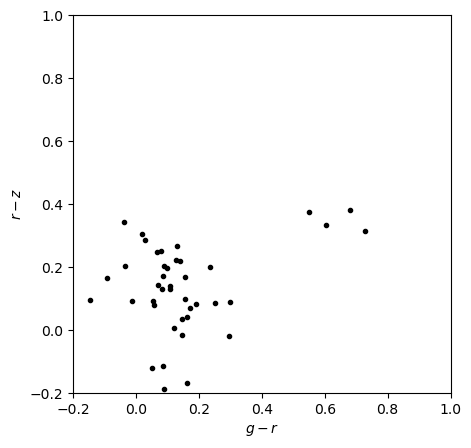

In [50]:
flux_g = np.array([row.Photometry.flux_g for row in q])
flux_r = np.array([row.Photometry.flux_r for row in q])
flux_z = np.array([row.Photometry.flux_z for row in q])
g_minus_r = np.log10(flux_r/flux_g)
r_minus_z = np.log10(flux_z/flux_r)
redshift = np.array([row.Zpix.z for row in q])
fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=100)
p = axes.plot(g_minus_r, r_minus_z, 'k.')
foo = axes.set_xlim([-0.2, 1.0])
foo = axes.set_ylim([-0.2, 1.0])
foo = axes.set_aspect('equal')
foo = axes.set_xlabel('$g - r$')
foo = axes.set_ylabel('$r - z$')

#### Exercise

* Create a color-color plot for objects targeted as QSOs, and spectroscopically confirmed as such.

In [96]:
q = db.dbSession.query(db.Zpix).filter(db.Zpix.spectype == 'QSO')[::10]

In [97]:
ra = [obj.mean_fiber_ra for obj in q]
dec = [obj.mean_fiber_dec for obj in q]

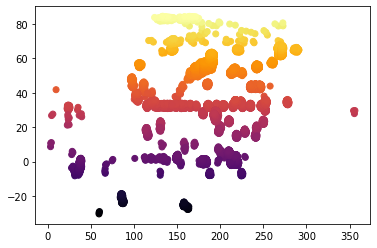

In [98]:
plt.scatter(ra, dec, c=dec, cmap='inferno')

### A More Complicated Join

Let's look at objects that appear on more than one tile. For each of those tiles, how many exposures where there?

In this example, we're using `sqlalchemy.sql.func` to get the equivalent of `COUNT(*)` and a subquery that itself is a multi-table join.

```SQL
SELECT t.nexp, f.tileid, q1.targetid, q1.n_assign FROM fuji.fiberassign AS f
    JOIN (SELECT ff.targetid, COUNT(*) AS n_assign FROM fuji.fiberassign AS ff GROUP BY ff.targetid) AS q1 ON f.targetid = q1.targetid
    JOIN fuji.tile AS t ON f.tileid = t.tileid LIMIT 100;
```

In [99]:
db.dbSession.rollback()
q1 = db.dbSession.query(db.Fiberassign.targetid, func.count('*').label('n_assign')).group_by(db.Fiberassign.targetid).subquery()
q2 = db.dbSession.query(db.Tile.nexp, db.Fiberassign.tileid, q1.c.targetid, q1.c.n_assign).filter(q1.c.n_assign>2).filter(db.Fiberassign.targetid == q1.c.targetid).filter(db.Tile.tileid == db.Fiberassign.tileid)

In [101]:
q2.count()

716866

Now let's see what the redshift table thinks are the number of exposures for these objects.

```SQL
SELECT z.* FROM fuji.zpix AS z WHERE z.targetid IN (6432023904256, 6448025174016[, ...]);
```

In [102]:
q3 = db.dbSession.query(db.Zpix).filter(db.Zpix.targetid.in_([row[2] for row in q2])).all()

(array([2.3240e+03, 0.0000e+00, 1.5326e+04, 0.0000e+00, 2.5460e+04,
        0.0000e+00, 0.0000e+00, 5.5461e+04, 0.0000e+00, 4.2962e+04,
        0.0000e+00, 2.7673e+04, 0.0000e+00, 0.0000e+00, 1.8846e+04,
        0.0000e+00, 1.2069e+04, 0.0000e+00, 0.0000e+00, 6.8490e+03,
        0.0000e+00, 4.8570e+03, 0.0000e+00, 2.9530e+03, 0.0000e+00,
        0.0000e+00, 2.6210e+03, 0.0000e+00, 6.3300e+03, 0.0000e+00,
        6.0000e+02, 0.0000e+00, 0.0000e+00, 4.8200e+02, 0.0000e+00,
        1.7020e+03, 0.0000e+00, 0.0000e+00, 6.2100e+02, 0.0000e+00,
        1.1300e+02, 0.0000e+00, 7.2000e+01, 0.0000e+00, 0.0000e+00,
        2.3400e+02, 0.0000e+00, 3.1300e+02, 0.0000e+00, 0.0000e+00,
        2.3200e+02, 0.0000e+00, 4.8000e+01, 0.0000e+00, 1.4600e+02,
        0.0000e+00, 0.0000e+00, 1.1000e+01, 0.0000e+00, 9.0000e+00,
        0.0000e+00, 1.6000e+01, 0.0000e+00, 0.0000e+00, 2.0000e+00,
        0.0000e+00, 7.0000e+00, 0.0000e+00, 0.0000e+00, 1.6000e+01,
        0.0000e+00, 1.1100e+02, 0.0000e+00, 1.01

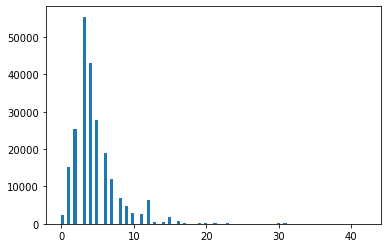

In [107]:
num_exp = [row.coadd_numexp for row in q3]
plt.hist(num_exp, bins=100)

#### Exercise

* What is the distribution of number of exposures?

## Fly me to the Moon

How does the Moon affect redshifts?  First, let's find exposures that exposures that had the Moon above the horizon.

In [108]:
moon_up = [e.expid for e in db.dbSession.query(db.Exposure).all() if ephem.moon(e.mjd, e.tilera, e.tiledec)[1] > 0]
len(moon_up)

902

In [109]:
moon_up

[90250,
 87505,
 87382,
 87126,
 87128,
 87263,
 87381,
 87259,
 87618,
 79308,
 79309,
 79310,
 79311,
 77579,
 83748,
 83448,
 83166,
 83010,
 83011,
 86514,
 85637,
 86756,
 90247,
 86627,
 86508,
 87124,
 86757,
 87122,
 86987,
 86988,
 87125,
 85636,
 86511,
 87617,
 86509,
 86626,
 83891,
 86993,
 87261,
 87127,
 87262,
 90249,
 86513,
 86755,
 86753,
 86015,
 86013,
 86269,
 86260,
 86264,
 86252,
 86019,
 86256,
 86378,
 86384,
 86388,
 86392,
 86258,
 86254,
 86251,
 86011,
 86017,
 86382,
 86504,
 85635,
 90246,
 86758,
 86625,
 87123,
 87380,
 90245,
 87257,
 87506,
 87129,
 87121,
 90239,
 86986,
 86515,
 85082,
 85502,
 85503,
 90240,
 85628,
 85340,
 87385,
 86619,
 86618,
 87264,
 87384,
 86620,
 86518,
 79576,
 79577,
 74463,
 74462,
 85509,
 85508,
 85507,
 86622,
 86621,
 74829,
 74830,
 74831,
 74832,
 85078,
 86741,
 85189,
 86617,
 86616,
 85196,
 86495,
 85626,
 85075,
 85343,
 85627,
 85624,
 85623,
 85622,
 85621,
 85620,
 82359,
 82495,
 82360,
 82354,
 81859,


So there are a few.  But there is a subtle issue: redshifts are based on *all* exposures, and the exposures are deliberately designed to enforce the bright/dark dichotomy in targeting. There are execptions though: certain LRGs also get targeted in the BGS & MWS, so that's not hard to capture. 

In [110]:
various_lrgs = (desi_mask.LRG | desi_mask.BGS_ANY | desi_mask.MWS_ANY)
various_lrgs

3458764513820540929

```SQL
SELECT z.targetid, z.z, z.zerr, z.zwarn
    FROM fuji.ztile AS z
    JOIN fuji.target AS t ON z.targetphotid = t.id
    JOIN fuji.fiberassign AS f ON t.targetid = f.targetid
    JOIN fuji.exposure AS e ON f.tileid == e.tileid
    WHERE z.spgrp = 'cumulative'
    AND t.desi_target & 3458764513820540929 != 0
    AND e.expid IN (90250, 87505, 87382[...]);
```

In [111]:
q_up = db.dbSession.query(db.Ztile.targetid, db.Ztile.z, db.Ztile.zerr, db.Ztile.zwarn)\
                   .join(db.Target, db.Target.id==db.Ztile.targetphotid)\
                   .join(db.Fiberassign, db.Target.targetid==db.Fiberassign.targetid)\
                   .join(db.Exposure, db.Fiberassign.tileid==db.Exposure.tileid)\
                   .filter(db.Ztile.spgrp=='cumulative')\
                   .filter(db.Target.desi_target.op('&')(various_lrgs) != 0)\
                   .filter(db.Exposure.expid.in_(moon_up)).all()

```SQL
SELECT z.targetid, z.z, z.zerr, z.zwarn
    FROM fuji.ztile AS z
    JOIN fuji.target AS t ON z.targetphotid = t.id
    JOIN fuji.fiberassign AS f ON t.targetid = f.targetid
    JOIN fuji.exposure AS e ON f.tileid == e.tileid
    WHERE z.spgrp = 'cumulative'
    AND t.desi_target & 3458764513820540929 != 0
    AND e.expid NOT IN (90250, 87505, 87382[...]);
```

In [114]:
q_dn = db.dbSession.query(db.Ztile.targetid, db.Ztile.z, db.Ztile.zerr, db.Ztile.zwarn)\
                   .join(db.Target, db.Target.id==db.Ztile.targetphotid)\
                   .join(db.Fiberassign, db.Target.targetid==db.Fiberassign.targetid)\
                   .join(db.Exposure, db.Fiberassign.tileid==db.Exposure.tileid)\
                   .filter(db.Ztile.spgrp=='cumulative')\
                   .filter(db.Target.desi_target.op('&')(various_lrgs) != 0)\
                   .filter(~db.Exposure.expid.in_(moon_up)).all()

Unfortunately however, the database currently only contains cumulative tile redshifts, not per-exposure redshifts, so it's not really meaningful to say whether the Moon was up or not. We'll just call this a work in progress.

In [1]:
#q_up

NameError: name 'q_up' is not defined

In [116]:
#q_dn

## Survey Progress

Let's see which nights have data, and count the number of exposures per night.

```SQL
SELECT e.night, COUNT(e.expid) AS n_exp FROM fuji.exposure AS e GROUP BY e.night ORDER BY e.night;
```

In [117]:
q = db.dbSession.query(db.Exposure.night, func.count(db.Exposure.expid).label('n_exp')).group_by(db.Exposure.night).order_by(db.Exposure.night).all()
q

[(20201214, 17),
 (20201215, 23),
 (20201216, 24),
 (20201217, 7),
 (20201218, 27),
 (20201219, 34),
 (20201220, 29),
 (20201221, 46),
 (20201222, 24),
 (20201223, 29),
 (20210101, 33),
 (20210102, 44),
 (20210103, 42),
 (20210105, 37),
 (20210106, 27),
 (20210107, 45),
 (20210108, 25),
 (20210109, 38),
 (20210110, 26),
 (20210111, 25),
 (20210114, 1),
 (20210115, 35),
 (20210116, 39),
 (20210130, 24),
 (20210131, 16),
 (20210201, 7),
 (20210202, 16),
 (20210203, 15),
 (20210204, 9),
 (20210205, 53),
 (20210206, 27),
 (20210208, 36),
 (20210212, 19),
 (20210214, 34),
 (20210215, 11),
 (20210216, 28),
 (20210217, 19),
 (20210218, 25),
 (20210220, 27),
 (20210221, 31),
 (20210222, 16),
 (20210223, 22),
 (20210224, 17),
 (20210228, 7),
 (20210304, 15),
 (20210305, 27),
 (20210306, 36),
 (20210308, 19),
 (20210309, 34),
 (20210313, 5),
 (20210314, 25),
 (20210315, 1),
 (20210316, 14),
 (20210317, 9),
 (20210318, 31),
 (20210319, 43),
 (20210320, 9),
 (20210321, 25),
 (20210322, 25),
 (2021

Observation timestamp for a given night.  Note how we have both MJD and a corresponding `datetime.datetime` object in the database.

```SQL
SELECT e.expid, e.mjd, e.date_obs FROM fuji.exposure AS e WHERE e.night = 20210428 ORDER BY e.expid;
```

In [121]:
q = db.dbSession.query(db.Exposure.expid, db.Exposure.mjd, db.Exposure.date_obs).filter(db.Exposure.night == 20210428).order_by(db.Exposure.expid).all()
q

[(86493, 59333.21675472, datetime.datetime(2021, 4, 29, 5, 12, 7, 607808, tzinfo=datetime.timezone.utc)),
 (86494, 59333.22358025, datetime.datetime(2021, 4, 29, 5, 21, 57, 333600, tzinfo=datetime.timezone.utc)),
 (86495, 59333.2315314, datetime.datetime(2021, 4, 29, 5, 33, 24, 312960, tzinfo=datetime.timezone.utc)),
 (86503, 59333.30986707, datetime.datetime(2021, 4, 29, 7, 26, 12, 514848, tzinfo=datetime.timezone.utc)),
 (86504, 59333.32705906, datetime.datetime(2021, 4, 29, 7, 50, 57, 902784, tzinfo=datetime.timezone.utc)),
 (86505, 59333.33191879, datetime.datetime(2021, 4, 29, 7, 57, 57, 783456, tzinfo=datetime.timezone.utc)),
 (86507, 59333.37990237, datetime.datetime(2021, 4, 29, 9, 7, 3, 564768, tzinfo=datetime.timezone.utc)),
 (86508, 59333.38628676, datetime.datetime(2021, 4, 29, 9, 16, 15, 176064, tzinfo=datetime.timezone.utc)),
 (86509, 59333.39238268, datetime.datetime(2021, 4, 29, 9, 25, 1, 863552, tzinfo=datetime.timezone.utc)),
 (86511, 59333.40257555, datetime.datetime

So, for a given target in the `target` table, when was the observation completed?  In other words, if a target has multiple observations, we want the date of the *last* observation.  First, how many targets are there?

```SQL
SELECT COUNT(*) FROM fuji.target;
```

In [122]:
N_targets = db.dbSession.query(db.Target).count()
N_targets

16460561

Now we look for targets that have observations and find the MJD of the observation.

```SQL
SELECT f.targetid, e.expid, e.mjd FROM fuji.fiberassign AS f
    JOIN (SELECT tt.targetid FROM fuji.target AS tt JOIN fuji.fiberassign AS ff ON tt.targetid = ff.targetid
              JOIN fuji.exposure AS ee ON ff.tileid = ee.tileid GROUP BY tt.targetid) AS q1 ON f.targetid = q1.targetid
    JOIN fuji.exposure AS e ON f.tileid = e.tileid ORDER BY q1.targetid, e.expid;
```

In [123]:
#
# Find all targetids that have observations.
#
q1 = db.dbSession.query(db.Target.targetid).filter(db.Target.targetid == db.Fiberassign.targetid).filter(db.Fiberassign.tileid == db.Exposure.tileid).group_by(db.Target.targetid).subquery()
#
# Find the exposure times for the targetids that have been observed
#
q2 = db.dbSession.query(db.Fiberassign.targetid, db.Exposure.expid, db.Exposure.mjd).filter(db.Fiberassign.targetid == q1.c.targetid).filter(db.Fiberassign.tileid == db.Exposure.tileid).order_by(q1.c.targetid, db.Exposure.expid).all()
targetid, expid, mjd = zip(*q2)
targetid = np.array(targetid)
expid = np.array(expid)
mjd = np.array(mjd)
#
# Use the counts to give the *last* observation.
#
unique_targetid, i, j, c = np.unique(targetid, return_index=True, return_inverse=True, return_counts=True)
unique_expid = expid[i + (c-1)]
unique_mjd = mjd[i + (c-1)]

Now we have the targets and the date of last observation.  But it's sorted by `targetid`.

In [124]:
ii = unique_expid.argsort()
unique_targetid, i3, j3, c3 = np.unique(unique_expid[ii], return_index=True, return_inverse=True, return_counts=True)
N_completed = np.cumsum(c3)

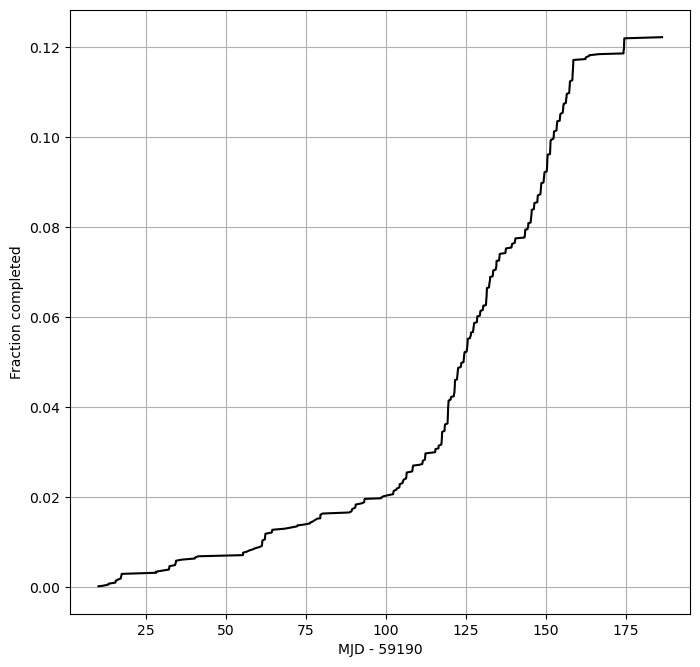

In [125]:
min_mjd = 10*(int(mjd.min())//10)
fig, axes = plt.subplots(1, 1, figsize=(8, 8), dpi=100)
p1 = axes.plot(unique_mjd[ii][i3] - min_mjd, N_completed/N_targets, 'k-')
foo = axes.set_xlabel(f'MJD - {min_mjd:d}')
foo = axes.set_ylabel('Fraction completed')
foo = axes.grid(True)
# foo = axes.legend(loc=1)

### Exercise

* Break down the progress by target class, target bit, etc.

## Using Relationships in SQLAlchemy

Here we demonstrate how table relationships can simplify certain queries. First we grab a single `db.Exposure` object.

```SQL
SELECT * FROM fuji.exposure where expid = 86507;
```

In [126]:
exposure = db.dbSession.query(db.Exposure).filter(db.Exposure.expid == 86507).one()
exposure

Exposure(night=20210428, expid=86507, tileid=401)

How do we get the `db.Frame` objects associated with this exposure?

In [134]:
exposure.frames

[Frame(expid=86507, camera='b0'),
 Frame(expid=86507, camera='b1'),
 Frame(expid=86507, camera='b2'),
 Frame(expid=86507, camera='b3'),
 Frame(expid=86507, camera='b4'),
 Frame(expid=86507, camera='b5'),
 Frame(expid=86507, camera='b6'),
 Frame(expid=86507, camera='b7'),
 Frame(expid=86507, camera='b8'),
 Frame(expid=86507, camera='b9'),
 Frame(expid=86507, camera='r0'),
 Frame(expid=86507, camera='r1'),
 Frame(expid=86507, camera='r2'),
 Frame(expid=86507, camera='r3'),
 Frame(expid=86507, camera='r4'),
 Frame(expid=86507, camera='r5'),
 Frame(expid=86507, camera='r6'),
 Frame(expid=86507, camera='r7'),
 Frame(expid=86507, camera='r8'),
 Frame(expid=86507, camera='r9'),
 Frame(expid=86507, camera='z0'),
 Frame(expid=86507, camera='z1'),
 Frame(expid=86507, camera='z2'),
 Frame(expid=86507, camera='z3'),
 Frame(expid=86507, camera='z4'),
 Frame(expid=86507, camera='z5'),
 Frame(expid=86507, camera='z6'),
 Frame(expid=86507, camera='z7'),
 Frame(expid=86507, camera='z8'),
 Frame(expid=8

What tile is associated with this exposure?

In [129]:
exposure.tile

Tile(tileid=401)

What fiberassignments were made on this tile?

In [130]:
exposure.tile.fiberassign[:20]

[Fiberassign(tileid=401, targetid=2305843019003212516, location=1483),
 Fiberassign(tileid=401, targetid=2305843019003213608, location=1464),
 Fiberassign(tileid=401, targetid=2305843019003212073, location=521),
 Fiberassign(tileid=401, targetid=2305843019003213545, location=520),
 Fiberassign(tileid=401, targetid=2305843019003224230, location=519),
 Fiberassign(tileid=401, targetid=2305843019003217368, location=505),
 Fiberassign(tileid=401, targetid=2305843019003207059, location=1416),
 Fiberassign(tileid=401, targetid=2305843019003208522, location=1418),
 Fiberassign(tileid=401, targetid=2305843019003205573, location=1442),
 Fiberassign(tileid=401, targetid=2305843019003214342, location=1443),
 Fiberassign(tileid=401, targetid=2305843019003213965, location=1420),
 Fiberassign(tileid=401, targetid=2305843019003214124, location=1396),
 Fiberassign(tileid=401, targetid=2305843019003213725, location=1419),
 Fiberassign(tileid=401, targetid=2305843019003215192, location=1395),
 Fiberassi

What redshifts were measured on this tile?

In [131]:
exposure.tile.ztile_redshifts[:20]

[Ztile(targetid=2305843019007400014, tileid=401, spgrp='cumulative', spgrpval=20210428),
 Ztile(targetid=2305843019007397295, tileid=401, spgrp='cumulative', spgrpval=20210428),
 Ztile(targetid=2305843019007394719, tileid=401, spgrp='cumulative', spgrpval=20210428),
 Ztile(targetid=2305843019007399070, tileid=401, spgrp='cumulative', spgrpval=20210428),
 Ztile(targetid=2305843019007396417, tileid=401, spgrp='cumulative', spgrpval=20210428),
 Ztile(targetid=2305843019007394531, tileid=401, spgrp='cumulative', spgrpval=20210428),
 Ztile(targetid=2305843019007398261, tileid=401, spgrp='cumulative', spgrpval=20210428),
 Ztile(targetid=2305843019007400147, tileid=401, spgrp='cumulative', spgrpval=20210428),
 Ztile(targetid=2305843019007399056, tileid=401, spgrp='cumulative', spgrpval=20210428),
 Ztile(targetid=2305843019007397105, tileid=401, spgrp='cumulative', spgrpval=20210428),
 Ztile(targetid=2305843019007398534, tileid=401, spgrp='cumulative', spgrpval=20210428),
 Ztile(targetid=23058

In [153]:
q = db.dbSession.query(db.Exposure)
q.count()

2480

In [154]:
qr = [exp for exp in q if len(exp.frames) != 30]

In [160]:
qr[10].frames[0].mjd

59307.45171179

### Exercise

* Rewrite example queries above using relationships wherever possible.

## Using q3c in SQLAlchemy

[q3c](https://github.com/segasai/q3c) ([Koposov & Bartunov 2006](https://ui.adsabs.harvard.edu/abs/2006ASPC..351..735K/abstract)) is a popular library that provides spatial indexing and searching in astronomical databases. Here we'll demonstrate how to access this functionality in SQLAlchemy.  Any database function is accessible with `sqlalchemy.sql.func`.  This is a radial ("cone") search on an arbitrary point in the DESI footprint:

```SQL
SELECT p.*, z.*, q3c_dist(p.ra, p.dec, 180.0, 0.0) AS radial_distance
    FROM fuji.photometry AS p JOIN fuji.zpix AS z ON p.targetid = z.targetid
    WHERE q3c_radial_query(p.ra, p.dec, 180.0, 0.0, 1.0/60.0); -- 1 arcmin
```

In [161]:
q = db.dbSession.query(db.Photometry, db.Zpix, func.q3c_dist(db.Photometry.ra, db.Photometry.dec, 180.0, 0.0).label("radial_distance")).join(db.Zpix).filter(func.q3c_radial_query(db.Photometry.ra, db.Photometry.dec, 180.0, 0.0, 1.0/60.0)).all()  # 1 arcmin
q

[(Photometry(targetid=39627787744581338), Zpix(targetid=39627787744581338, survey='sv1', program='dark'), 0.0155553060060447),
 (Photometry(targetid=39627787744581338), Zpix(targetid=39627787744581338, survey='sv3', program='dark'), 0.0155553060060447),
 (Photometry(targetid=39627787744581419), Zpix(targetid=39627787744581419, survey='sv3', program='bright'), 0.0162460808451895),
 (Photometry(targetid=2305843037487501690), Zpix(targetid=2305843037487501690, survey='sv3', program='backup'), 0.0155599700637323),
 (Photometry(targetid=39627787744581040), Zpix(targetid=39627787744581040, survey='sv3', program='bright'), 0.0166239589966163),
 (Photometry(targetid=39627787744581068), Zpix(targetid=39627787744581068, survey='sv3', program='bright'), 0.0154899710431295),
 (Photometry(targetid=39627787744581408), Zpix(targetid=39627787744581408, survey='sv3', program='bright'), 0.00272573517354215),
 (Photometry(targetid=39627787748769959), Zpix(targetid=39627787748769959, survey='sv3', program

### Exercise

* What spectra are near your favourite object?